In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf

### EDA

Pull in data.

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Descriptive statistics.

In [3]:
round(data.describe(), 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


Feature distributions.

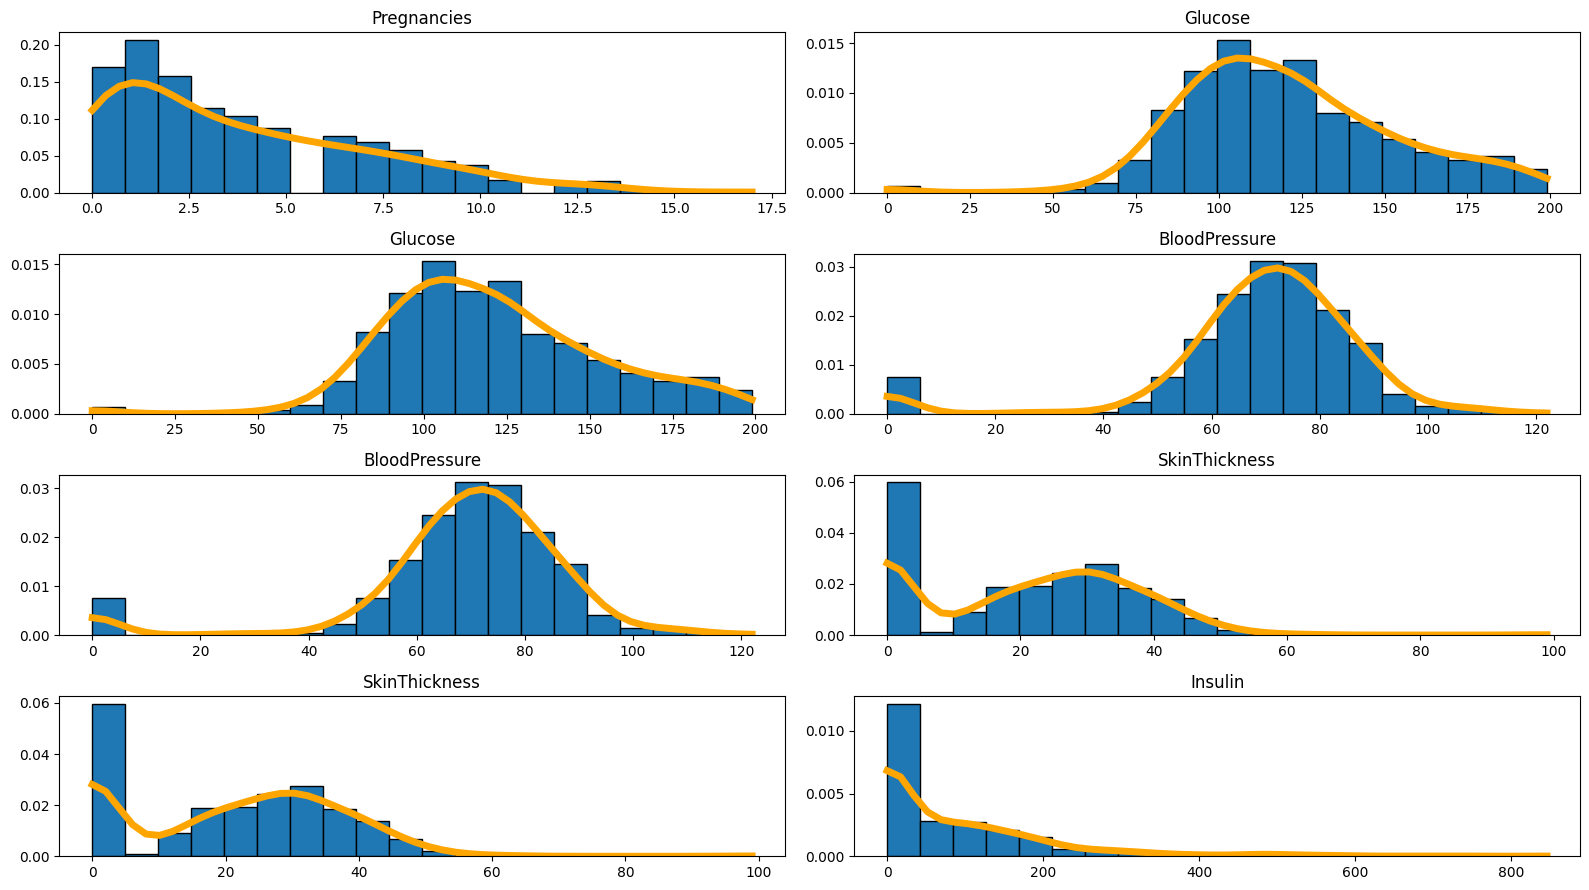

In [4]:
fig, axs = plt.subplots(4, 2, figsize=[16,9])

for i in range(4):
    for j in range(2):
        col = data.iloc[:,i + j]
        
        axs[i][j].hist(col, bins=20, edgecolor='black', density=True)
        
        x = ss.gaussian_kde(col)
        lin = np.linspace(col.min(), col.max(), 50)
        
        axs[i][j].plot(lin, x(lin), color='orange', linewidth=5)
        axs[i][j].set_title(col.name)
        
fig.tight_layout()
plt.show()

Outcome is the target label we are trying to predict. We see that roughly a third of the patients in the data set have a positive diabetes test.

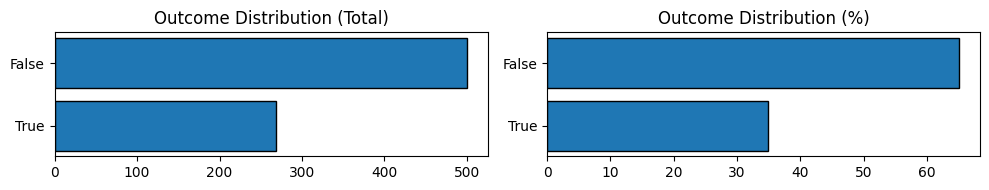

In [5]:
fig, axs = plt.subplots(1, 2, figsize=[10,2])

axs[0].barh([0, 1], [(data['Outcome'] == True).sum(), (data['Outcome'] == False).sum()], edgecolor='Black')
axs[1].barh([0, 1], [100 * (data['Outcome'] == True).sum() / len(data), 100 * (data['Outcome'] == False).sum() / len(data)], edgecolor='Black')
axs[0].set_yticks([0, 1], labels=['True', 'False'])
axs[1].set_yticks([0, 1], labels=['True', 'False'])
axs[0].set_title('Outcome Distribution (Total)')
axs[1].set_title('Outcome Distribution (%)')
fig.tight_layout()
plt.show()

### Data Cleaning

In [6]:
X = data.drop(columns=['Outcome'])
y = data[['Outcome']]

We will split the data into a training set (60%), a test set (20%), and a validation set (20%).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=11)

### Model Fitting

We will be using TensorFlow to implement our neural network model. Our model will use one hidden layer with 4 nodes that use a relu activation functions and then an output layer that uses the sigmoid function. We use the sigmoid function in the output layer because we are performing a classification exercise.

In [8]:
def create_model(learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(8,)))
    model.add(tf.keras.layers.Dense(4, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)     # Use .legacy version on M1/M2 Macs
    loss = tf.keras.losses.BinaryCrossentropy()

    model.compile(loss=loss, optimizer=optimizer)

    return model

In [9]:
def process_data(X):
    normalize = tf.keras.layers.Normalization(axis=1)
    normalize.adapt(X)
    X_norm = normalize(X)

    return X_norm

First we need to process our data by normalizing it. To normalize it we take each column of our feature dataframes and apply the following function:

$$ f(x) = \frac {X - \mu}{\sigma} $$

In [10]:
X_train_norm = process_data(X_train)
X_val_norm = process_data(X_val)
X_test_norm = process_data(X_test)

Next, we instantiate an initial model to ensure that our create_model function is working.

In [25]:
tf.random.set_seed(43)
tf.keras.utils.set_random_seed(43)
learning_rate = .1
model = create_model(learning_rate)
model.fit(X_train_norm, y_train, epochs=300, batch_size=50)

Epoch 1/300
10/10 [==============================] - 0s 697us/step - loss: 0.6448
Epoch 2/300
10/10 [==============================] - 0s 652us/step - loss: 0.4710
Epoch 3/300
10/10 [==============================] - 0s 736us/step - loss: 0.4420
Epoch 4/300
10/10 [==============================] - 0s 510us/step - loss: 0.4345
Epoch 5/300
10/10 [==============================] - 0s 495us/step - loss: 0.4258
Epoch 6/300
10/10 [==============================] - 0s 584us/step - loss: 0.4258
Epoch 7/300
10/10 [==============================] - 0s 471us/step - loss: 0.4172
Epoch 8/300
10/10 [==============================] - 0s 669us/step - loss: 0.4164
Epoch 9/300
10/10 [==============================] - 0s 485us/step - loss: 0.4085
Epoch 10/300
10/10 [==============================] - 0s 432us/step - loss: 0.4296
Epoch 11/300
10/10 [==============================] - 0s 649us/step - loss: 0.4122
Epoch 12/300
10/10 [==============================] - 0s 439us/step - loss: 0.4113
Epoch 13/300


Here are the different hyperparameter values that we will optimize the model to.

In [12]:
parameters = {'learning_rate' : [.1, .01, .001, .0001],
              'epochs' : [50, 100, 200, 300],
              'batch_size' : [0.0, 0.2, 0.4]
}

We run a grid search to find the best hyperparameters. We will evaluate a model's fit by its accuracy on our validation set.

In [13]:
train_losses = {}
val_losses = {}

total = 1
for i in parameters.values():
    total *= len(i)

print('Models Fitted: %d/%d (%.2f%%)' % (0, total, 0), end='\r')
count = 1
for learning_rate in parameters['learning_rate']:
    for epochs in parameters['epochs']:
        for batch_size in parameters['batch_size']:            
            model = create_model(learning_rate)
            model.fit(X_train_norm,
                      y_train,
                      epochs=epochs,
                      batch_size=int(batch_size * len(X_train_norm)),
                      validation_data=(X_val_norm, y_val),
                      verbose=0)

            train_losses.update({(learning_rate, epochs, batch_size) : model.history.history['loss'][-1]})
            val_losses.update({(learning_rate, epochs, batch_size) : model.history.history['val_loss'][-1]})

            print('Models Trained: %d/%d (%.2f%%)' % (count, total, 100 * count / total), end='\r')
            count += 1

In [14]:
results = pd.DataFrame({'train_loss' : train_losses, 'val_loss' : val_losses})
results = results.reset_index()
results.columns = ['learning_rate', 'epochs', 'batch_size', 'train_score', 'val_score']
results = results.sort_values('val_score', ascending=True)
results.head()

,learning_rate,epochs,batch_size,train_score,val_score
34,0.001,300,0.2,0.435381,0.480937
32,0.001,200,0.4,0.470397,0.486672
15,0.010,100,0.0,0.424395,0.488272
20,0.010,200,0.4,0.394888,0.499211
31,0.001,200,0.2,0.445552,0.503799


In [15]:
print('Our best model has the following parameters')

for key, value in round(results.iloc[0][:3], 3).to_dict().items():
    print(key, '=', value)

Our best model has the following parameters
learning_rate = 0.001
epochs = 300.0
batch_size = 0.2


We have the best hyperparameters from the grid search. In a normal scenario, when our grid search picks a hyperparameter that is on the upper or lower edge of the range that we are testing, we would normally want to re-run the gridsearch with a  We create a fresh model with those hyperparameters and train it on our training data.

In [16]:
model = create_model(results.iloc[0]['learning_rate'])
model.fit(X_train_norm,
          y_train,
          epochs=int(results.iloc[0]['epochs']),
          batch_size=int(results.iloc[0]['batch_size'] * len(X_train_norm)),
          validation_data=(X_val_norm, y_val))

Epoch 1/300
5/5 [==============================] - 0s 12ms/step - loss: 0.8408 - val_loss: 0.7093
Epoch 2/300
5/5 [==============================] - 0s 3ms/step - loss: 0.8330 - val_loss: 0.7042
Epoch 3/300
5/5 [==============================] - 0s 3ms/step - loss: 0.8268 - val_loss: 0.6992
Epoch 4/300
5/5 [==============================] - 0s 3ms/step - loss: 0.8197 - val_loss: 0.6944
Epoch 5/300
5/5 [==============================] - 0s 3ms/step - loss: 0.8130 - val_loss: 0.6898
Epoch 6/300
5/5 [==============================] - 0s 3ms/step - loss: 0.8065 - val_loss: 0.6854
Epoch 7/300
5/5 [==============================] - 0s 3ms/step - loss: 0.8005 - val_loss: 0.6811
Epoch 8/300
5/5 [==============================] - 0s 3ms/step - loss: 0.7945 - val_loss: 0.6768
Epoch 9/300
5/5 [==============================] - 0s 3ms/step - loss: 0.7881 - val_loss: 0.6727
Epoch 10/300
5/5 [==============================] - 0s 3ms/step - loss: 0.7823 - val_loss: 0.6686
Epoch 11/300
5/5 [==========

We visualize the convergence of the model's loss below. We can notice that although the loss of the training set goes down, the loss of the validation set rises. This might point to the idea that the model is being overfit on to the nuances of the training data and is therefore a worse fit on other data sets.

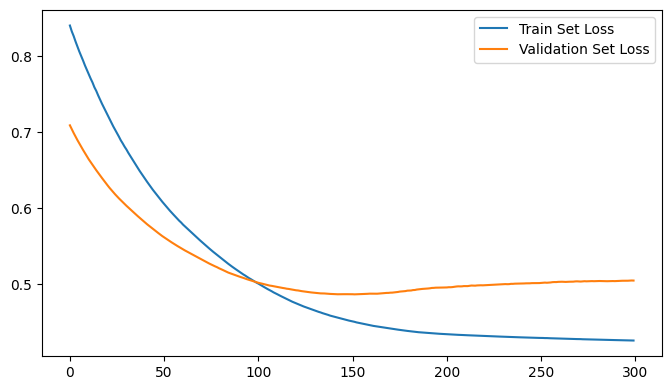

In [17]:
plt.figure(figsize=[8,4.5])
plt.plot(model.history.history['loss'], label='Train Set Loss')
plt.plot(model.history.history['val_loss'], label='Validation Set Loss')
plt.legend()
plt.show()

We will assume that a prediction probability of 0.5 or greater is classified as True and anything else as False.

In [18]:
preds_test = model.predict(X_test_norm)
results_test = pd.DataFrame({'Target' : np.array(y_test).T[0], 'True Prob' : preds_test.T[0], 'False Prob' : 1 - preds_test.T[0]})
results_test['Target'] = results_test['Target'].astype(bool)
results_test['Prediction'] = results_test['True Prob'] >= .5
results_test['Correct'] = results_test['Target'] == results_test['Prediction']
results_test.head()

5/5 [==============================] - 0s 607us/step


,Target,True Prob,False Prob,Prediction,Correct
0,True,0.359433,0.640567,False,False
1,False,0.322567,0.677433,False,True
2,False,0.188556,0.811444,False,True
3,True,0.805183,0.194817,True,True
4,True,0.436021,0.563979,False,False


In [19]:
a = 100 * results_test[results_test['Target'] == True]['Correct'].sum() / len(results_test[results_test['Target'] == True])
print('Guessed Test True Correctly %.2f%%' % a)
b = 100 * results_test[results_test['Target'] == False]['Correct'].sum() / len(results_test[results_test['Target'] == False])
print('Guessed Test False Correctly %.2f%%' % b)
c = 100 * results_test['Correct'].sum() / len(results_test)
print('Guessed Test Correctly %.2f%%' % c)

Guessed Test True Correctly 48.33%
Guessed Test False Correctly 85.11%
Guessed Test Correctly 70.78%


In [20]:
preds_train = model.predict(X_train_norm)
results_train = pd.DataFrame({'Target' : np.array(y_train).T[0], 'True Prob' : preds_train.T[0], 'False Prob' : 1 - preds_train.T[0]})
results_train['Target'] = results_train['Target'].astype(bool)
results_train['Prediction'] = results_train['True Prob'] >= .5
results_train['Correct'] = results_train['Target'] == results_train['Prediction']
results_train.head()

15/15 [==============================] - 0s 708us/step


,Target,True Prob,False Prob,Prediction,Correct
0,True,0.699759,0.300241,True,True
1,False,0.569985,0.430015,True,False
2,False,0.120833,0.879167,False,True
3,False,0.353371,0.646629,False,True
4,True,0.309484,0.690516,False,False


In [21]:
a = 100 * results_train[results_train['Target'] == True]['Correct'].sum() / len(results_train[results_train['Target'] == True])
print('Guessed Train True Correctly %.2f%%' % a)
b = 100 * results_train[results_train['Target'] == False]['Correct'].sum() / len(results_train[results_train['Target'] == False])
print('Guessed Train False Correctly %.2f%%' % b)
c = 100 * results_train['Correct'].sum() / len(results_train)
print('Guessed Train Correctly %.2f%%' % c)

Guessed Train True Correctly 66.05%
Guessed Train False Correctly 87.58%
Guessed Train Correctly 80.00%


We see that our model predicts better on our training data than on our test data, which is expected. However, the model is still able to predict diabetes correctly in +70% of our test instances, which is a reasonable result.

In [22]:
preds_val = model.predict(X_val_norm)
results_val = pd.DataFrame({'Target' : np.array(y_val).T[0], 'True Prob' : preds_val.T[0], 'False Prob' : 1 - preds_val.T[0]})
results_val['Target'] = results_val['Target'].astype(bool)
results_val['Prediction'] = results_val['True Prob'] >= .5
results_val['Correct'] = results_val['Target'] == results_val['Prediction']

5/5 [==============================] - 0s 932us/step


Here we look at the ROC Curve. If our curve was simply a straight diagonal line $(y=x)$, our model would have no predictive power, i.e. when the threshold of predicting a positive result vs. a negative result is raised our model's performance improves linearly. But we see that this is not the case for any of our three sets, so our model does have predictive power.

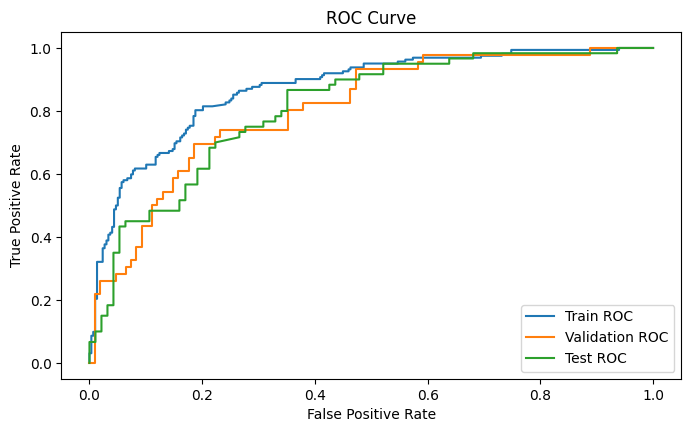

In [23]:
train_roc = roc_curve(results_train['Target'], results_train['True Prob'])
val_roc = roc_curve(results_val['Target'], results_val['True Prob'])
test_roc = roc_curve(results_test['Target'], results_test['True Prob'])

plt.figure(figsize=[8,4.5])
plt.plot(train_roc[0], train_roc[1], label='Train ROC')
plt.plot(val_roc[0], val_roc[1], label='Validation ROC')
plt.plot(test_roc[0], test_roc[1], label='Test ROC')
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

Next we look at our Confusion Matrix. We can see that when we predict negative, we get a true negative about 75% of the time and a false negative about 25% of the time. When we predict positive, we get a false positive about 25% of the time and a true positive about 75Í% of the time. This is a fairly balanced model because our false positive rate and our false negative rate are similar.

In [24]:
conf_mat = confusion_matrix(results_test['Target'], results_test['Prediction'], normalize='pred')
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = pd.MultiIndex.from_tuples([('Predicted Values', 'Negative'), ('Predicted Values', 'Positive')])
conf_mat.index = pd.MultiIndex.from_tuples([('Actual Values', 'Negative'), ('Actual Values', 'Positive')])
round(conf_mat * 100, 2).astype(str) + '%'

Predicted Values         
                               Negative Positive
Actual Values Negative           72.07%   32.56%
              Positive           27.93%   67.44%